In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
from sklearn.preprocessing import MinMaxScaler
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import load_model
from matplotlib import pyplot

Using TensorFlow backend.


In [19]:
df = pd.read_csv('data_by_id/135.csv', index_col="time",parse_dates=True)
df = df[4:]
df.head()

,adjusted_open,adjusted_high,adjusted_low,adjusted_close,adjusted_volume,id,moving_average
time,,,,,,,
1990-01-08,2.962156,2.999828,2.962156,2.985245,1353704.0,135,3.001651
1990-01-09,2.985245,2.999828,2.931775,2.931775,1061104.0,135,2.981843
1990-01-10,2.916584,2.931775,2.840631,2.901394,1217504.0,135,2.959118
1990-01-11,2.901394,2.977346,2.901394,2.939674,1147904.0,135,2.947087
1990-01-12,2.901394,2.962156,2.878912,2.962156,1964000.0,135,2.944049


In [21]:
training_set = df.drop(['id'], axis=1)
column = df['adjusted_open'].count()
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled[column-10:])

[[0.98702925 0.98476772 0.98482021 0.99611412 0.09937353 0.99324599]
 [0.99407297 0.99072096 0.99878562 1.         0.07200545 0.99466972]
 [1.         0.98961536 1.         0.99740941 0.0549955  0.99690948]
 [0.99312808 0.98663874 0.99661708 0.99326447 0.02273625 0.99836793]
 [0.98857543 0.98136586 0.98976448 0.98929224 0.03381791 1.        ]
 [0.9833356  0.97851681 0.98716223 0.98480189 0.03009169 0.99772551]
 [0.98187531 0.97660327 0.98950426 0.99076024 0.04574844 0.99586773]
 [0.98728695 0.97719859 0.98976448 0.9880833  0.02034292 0.99399258]
 [0.98565487 0.97541262 0.98733572 0.98851506 0.01664952 0.99303764]
 [0.97749446 0.9757528  0.98742246 0.98747883 0.02645002 0.99267303]]


In [22]:
X_test = []
y_test = []
regressor = load_model('test2.h5')
for i in range(column-100, column):
    X_test.append(training_set_scaled[i-60:i, :])
    y_test.append(training_set_scaled[i, :])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))
y_predicted = regressor.predict(X_test)

(100, 60, 6)


In [23]:
y_predicted = pd.DataFrame(y_predicted)
y_predicted.info()
y_predicted.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
0    100 non-null float32
1    100 non-null float32
2    100 non-null float32
3    100 non-null float32
4    100 non-null float32
5    100 non-null float32
dtypes: float32(6)
memory usage: 2.4 KB


,0,1,2,3,4,5
95,0.990312,0.977627,0.995021,0.984887,0.039612,1.008361
96,0.986997,0.974287,0.991755,0.981649,0.038514,1.005729
97,0.986978,0.974285,0.991715,0.981616,0.039436,1.005012
98,0.986513,0.973752,0.991383,0.981196,0.038120,1.004593
99,0.986331,0.973536,0.991272,0.981037,0.037387,1.004451


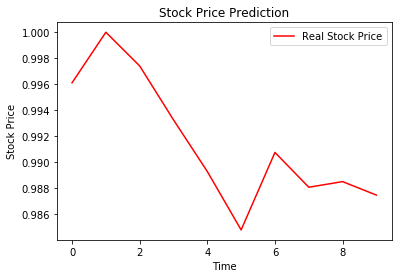

In [29]:
plt.plot(training_set_scaled[column-10:, 3], color = 'red', label = 'Real Stock Price')
#plt.plot(y_predicted[: 3], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [25]:
preds_moving = moving_test_window_preds(5)
print(preds_moving)
print((preds_moving[4]-preds_moving[0])/preds_moving[0])

(1, 60, 6)
0
1
2
3
4
[0.98488677, 0.9819981, 0.9797635, 0.9779916, 0.9770632]
-0.00794364


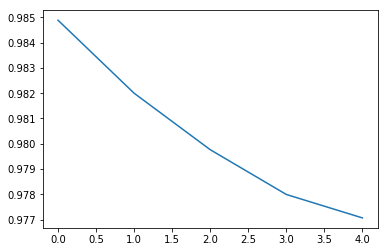

In [26]:
pyplot.plot(preds_moving)

In [13]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = [] # Use this to store the prediction made on each test window
    moving_test_window = []
    moving_test_window.append(training_set_scaled[column-65:column-5, :])      # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    moving_test_window = np.reshape(moving_test_window, (1, 60, 6))
    print(moving_test_window.shape)
    
    for i in range(n_future_preds):
        print(i)
        preds_one_step = regressor.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,3]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,6) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end)
    
    return preds_moving